In [54]:
import random
import torch
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np
import cv2

from pathlib import Path
from ultralytics import YOLO
from tqdm import tqdm
from transformers import SiglipImageProcessor, SiglipVisionModel
from PIL import Image
from collections import defaultdict
from sklearn.cluster import KMeans

In [45]:
MODEL_PATH = Path("runs/detect/train12/weights/best.pt")
VAL_IMAGES_DIR = Path("data/tracking/YOLO/images/val")
VIDEO_OUT_DIR = Path("videos")
VIDEO_OUT_DIR.mkdir(parents=True, exist_ok=True)

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = YOLO(str(MODEL_PATH))
model.to(device)
print("Loaded model from:", MODEL_PATH)

names = model.names  
print("Classes:", names)

Using device: cuda
Loaded model from: runs/detect/train12/weights/best.pt
Classes: {0: 'player', 1: 'referee', 2: 'ball'}


Inference on: SNMOT-159_000192.jpg


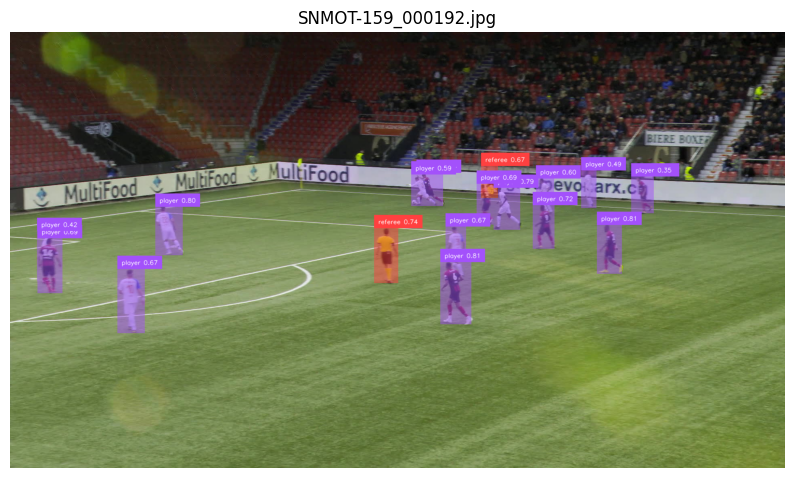

In [47]:
img_path = random.choice(list(Path(VAL_IMAGES_DIR).glob("*.jpg")))
print("Inference on:", img_path.name)

result = model(str(img_path), imgsz=640, device=device, verbose=False)[0]

detections = sv.Detections.from_ultralytics(result)

labels = [
    f"{names[int(cls_id)]} {conf:.2f}"
    for cls_id, conf in zip(detections.class_id, detections.confidence)
]

image_bgr = cv2.imread(str(img_path))

color_annotator = sv.ColorAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_bgr = color_annotator.annotate(
    scene=image_bgr.copy(),
    detections=detections
)
annotated_bgr = label_annotator.annotate(
    scene=annotated_bgr,
    detections=detections,
    labels=labels
)

annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title(img_path.name)
plt.show()

## Tracking

In [48]:

VAL_IMAGES_DIR = Path("data/tracking/YOLO/images/val")

all_imgs = list(VAL_IMAGES_DIR.glob("SNMOT-*_*.jpg"))

max_frames = 60

match_ids = sorted({p.stem.split("_")[0] for p in all_imgs})
print(f"Found {len(match_ids)} matches: {match_ids}")

selected_match = random.choice(match_ids)
print(f"Selected Match: {selected_match}")

match_frames = [p for p in all_imgs if p.stem.startswith(selected_match + "_")]

match_frames = sorted(match_frames, key=lambda p: int(p.stem.split("_")[1]))

if len(match_frames) > max_frames:
    match_frames = match_frames[:max_frames]

print(f"Frames to process: {len(match_frames)}")

Found 12 matches: ['SNMOT-159', 'SNMOT-160', 'SNMOT-161', 'SNMOT-162', 'SNMOT-163', 'SNMOT-164', 'SNMOT-165', 'SNMOT-166', 'SNMOT-167', 'SNMOT-168', 'SNMOT-169', 'SNMOT-170']
Selected Match: SNMOT-161
Frames to process: 60


In [49]:

model = YOLO("runs/detect/train12/weights/best.pt") 
tracker = sv.ByteTrack()

# List to store the output data for later use
tracking_results = [] 

print("Starting Tracking...")
for img_path in tqdm(match_frames):
    # 1. Load Frame
    frame = cv2.imread(str(img_path))
    
    # 2. Inference
    result = model(frame, imgsz=640, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)
    
    # 3. Track (Assigns IDs)
    # This is the magic step that persists IDs across frames
    detections = tracker.update_with_detections(detections)
    
    # 4. Store Result
    # We save the path and the detections object. 
    # This object now contains 'tracker_id'.
    tracking_results.append({
        "frame_path": img_path,
        "detections": detections,
        "frame_shape": frame.shape[:2] # (h, w)
    })

print(f"Tracking complete. Stored data for {len(tracking_results)} frames.")

Starting Tracking...


 22%|██▏       | 13/60 [00:00<00:01, 33.11it/s]

100%|██████████| 60/60 [00:01<00:00, 35.95it/s]

Tracking complete. Stored data for 60 frames.


In [50]:
for i, data in enumerate(tracking_results):
    dets = data["detections"]
    if len(dets) > 0:
        print(f"Frame {i}: Found {len(dets)} objects.")
        print("Tracker IDs:", dets.tracker_id)
        print("Class IDs:", dets.class_id)
        break
else:
    print("No detections found in the entire clip.")

Frame 0: Found 18 objects.
Tracker IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Class IDs: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [51]:
# === CELL 4: Generate Video ===
VIDEO_OUT_DIR = Path("videos")
VIDEO_OUT_DIR.mkdir(parents=True, exist_ok=True)

# Setup Video Writer
first_frame_shape = tracking_results[0]["frame_shape"] # (h, w)
out_path = VIDEO_OUT_DIR / f"{selected_match}_tracked.mp4"
fps = 25
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(str(out_path), fourcc, fps, (first_frame_shape[1], first_frame_shape[0]))

color_annotator = sv.ColorAnnotator()
label_annotator = sv.LabelAnnotator()

print(f"Rendering video to {out_path}...")

for data in tqdm(tracking_results):
    # Reload image from path (saves RAM vs keeping all images in memory)
    frame = cv2.imread(str(data["frame_path"]))
    detections = data["detections"]

    labels = [
        f"#{tracker_id} {model.names[int(cls_id)]}"
        for tracker_id, cls_id 
        in zip(detections.tracker_id, detections.class_id)
    ]

    # Annotate
    annotated = color_annotator.annotate(scene=frame, detections=detections)
    annotated = label_annotator.annotate(
        scene=annotated,
        detections=detections,
        labels=labels
    )

    writer.write(annotated)

writer.release()
print("Done!")

Rendering video to videos/SNMOT-161_tracked.mp4...


100%|██████████| 60/60 [00:02<00:00, 26.00it/s]

Done!


## Segmentación entre equipos


In [55]:
print("Loading SigLIP model...")
processor = SiglipImageProcessor.from_pretrained("google/siglip-base-patch16-224")
embed_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224").to(device)

def get_crop(frame, xyxy):
    """Crops the image and converts to PIL format (RGB)"""
    x1, y1, x2, y2 = map(int, xyxy)
    h, w = frame.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    if x2 - x1 < 10 or y2 - y1 < 10: 
        return None
        
    crop = frame[y1:y2, x1:x2]
    return Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))

print(f"Model loaded on {device}")

Loading SigLIP model...


Model loaded on cuda


In [56]:
# === CELL 6: Extract Embeddings per Player ===

# Dictionary to store crops: { tracker_id: [crop1, crop2, ...] }
player_tracks = defaultdict(list)
# We need to know which class ID corresponds to "Player"
# Assuming class 0 is player? Update this if your model is different!
PLAYER_CLASS_ID = 0 # <--- CHECK YOUR MODEL.NAMES (e.g., 'player': 0)

print("Extracting crops for embeddings...")

for data in tqdm(tracking_results):
    frame = cv2.imread(str(data["frame_path"]))
    dets = data["detections"]
    
    for i, (xyxy, cls_id, tracker_id) in enumerate(zip(dets.xyxy, dets.class_id, dets.tracker_id)):
        if int(cls_id) == PLAYER_CLASS_ID and tracker_id != -1:
            # Optimization: Only take 1 crop every 30 frames per player
            # This saves massive time/RAM and is enough for color info
            if len(player_tracks[tracker_id]) < 5: # Limit to 5 samples per player
                crop = get_crop(frame, xyxy)
                if crop:
                    player_tracks[tracker_id].append(crop)

# Generate Vector per Player
track_embeddings = {}

print(f"Generating embeddings for {len(player_tracks)} unique players...")
for tracker_id, crops in tqdm(player_tracks.items()):
    if not crops: continue
    
    # Batch process all crops for this player
    inputs = processor(images=crops, return_tensors="pt", padding="max_length").to(device)
    with torch.no_grad():
        outputs = embed_model(**inputs)
        # Average the vectors to get one stable representation
        avg_embedding = outputs.pooler_output.mean(dim=0).cpu().numpy()
        
    track_embeddings[tracker_id] = avg_embedding

print("Embeddings ready.")

Extracting crops for embeddings...


100%|██████████| 60/60 [00:00<00:00, 88.92it/s]


Generating embeddings for 21 unique players...


100%|██████████| 21/21 [00:00<00:00, 29.42it/s]

Embeddings ready.


In [57]:

ids = list(track_embeddings.keys())
vectors = np.array(list(track_embeddings.values()))

# Cluster into 2 teams
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(vectors)
labels = kmeans.labels_

# Create a lookup map: { tracker_id: team_id }
team_lookup = {t_id: team for t_id, team in zip(ids, labels)}

print(f"Clustered {len(ids)} players into 2 teams.")
print("Team 0 count:", list(labels).count(0))
print("Team 1 count:", list(labels).count(1))

Clustered 21 players into 2 teams.
Team 0 count: 10
Team 1 count: 11


In [60]:
# === CELL 8: Generate Final Video (Stable Colors) ===
import numpy as np

out_path = VIDEO_OUT_DIR / f"{selected_match}_teams_fixed.mp4"
writer = cv2.VideoWriter(str(out_path), fourcc, fps, (first_frame_shape[1], first_frame_shape[0]))

# 1. Define a fixed Palette for our 4 classes
# Order: [Team 0, Team 1, Referee, Ball]
colors = sv.ColorPalette([
    sv.Color(r=255, g=0, b=0),      # Class 0: Team 0 (Red)
    sv.Color(r=0, g=0, b=255),      # Class 1: Team 1 (Blue)
    sv.Color(r=255, g=255, b=0),    # Class 2: Referee (Yellow)
    sv.Color(r=0, g=255, b=0)       # Class 3: Ball (Green)
])

# Initialize annotators with this fixed palette
box_annotator = sv.BoxAnnotator(color=colors)
label_annotator = sv.LabelAnnotator(color=colors, text_color=sv.Color.WHITE)

print(f"Rendering stable video to {out_path}...")

for data in tqdm(tracking_results):
    frame = cv2.imread(str(data["frame_path"]))
    
    # Make a copy of detections so we can modify class_id safely
    detections = data["detections"]
    original_classes = detections.class_id.copy()
    
    # Arrays to store our new "Color Classes" and Labels
    new_class_ids = []
    labels = []
    
    for cls_id, tracker_id in zip(original_classes, detections.tracker_id):
        class_name = model.names[int(cls_id)]
        
        # Determine the new "Color Class" ID (0, 1, 2, or 3)
        if class_name == "ball":
            new_class_ids.append(3) # Green
            labels.append("Ball")
            
        elif class_name == "referee":
            new_class_ids.append(2) # Yellow
            labels.append("Ref")
            
        else:
            # Players
            team = team_lookup.get(tracker_id)
            if team == 0:
                new_class_ids.append(0) # Red
                labels.append(f"#{tracker_id}") 
            elif team == 1:
                new_class_ids.append(1) # Blue
                labels.append(f"#{tracker_id}")
            else:
                # Fallback (Tracked but no embedding yet, e.g. new player enters)
                new_class_ids.append(2) # Assign to Ref color or a neutral color
                labels.append(f"#{tracker_id}")

    # APPLY THE HACK: Overwrite class_ids with our color logic
    # This forces the annotator to pick the color based on Team, not original Class
    detections.class_id = np.array(new_class_ids)

    # Annotate
    annotated = box_annotator.annotate(scene=frame, detections=detections)
    annotated = label_annotator.annotate(
        scene=annotated,
        detections=detections,
        labels=labels
    )

    writer.write(annotated)
    
    # Restore original classes (optional, but good practice if you re-use data)
    detections.class_id = original_classes

writer.release()
print("Done! Colors should now be perfectly stable.")

Rendering stable video to videos/SNMOT-161_teams_fixed.mp4...


100%|██████████| 60/60 [00:01<00:00, 30.13it/s]

Done! Colors should now be perfectly stable.
